In [1]:
from math import cos, log, pi, sqrt

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [2]:
# 1. Random number generator

# 1.a
def BoxMuller(mean, var):
    # y = x*sigma + var
    # => y = sqrt(-2*ln(a)) * cos(2*pi*b) * sigma + mu
    a = np.random.uniform()
    b = np.random.uniform()
    sigma = np.sqrt(var)

    y = sqrt(-2 * log(a)) * cos(2 * pi * b) * sigma + mean
    return y


def printGaussianDist(mean, var):
    Gaussian = []
    for i in range(10000):
        Gaussian.append(BoxMuller(mean, var))
    plt.hist(Gaussian, 100)
    # plt.savefig("Gaussian")
    plt.show()
    plt.clf()

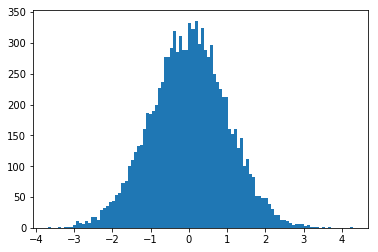

<Figure size 432x288 with 0 Axes>

In [3]:
printGaussianDist(0, 1)

In [4]:
# 1.b
def polyBasis(n, a, w):
    e = BoxMuller(mean=0, var=a)
    x = np.random.uniform(-1, 1)
    polyFunc = np.polynomial.polynomial.Polynomial(w)
    y = polyFunc(x) + e
    return [x, y]


def printPolyBasis(n, a, w):
    x = []
    y = []
    for _ in range(10000):
        res = polyBasis(n, a, w)
        x.append(res[0])
        y.append(res[1])
    plt.xlim(-2, 2)
    plt.ylim(-20, 30)
    plt.scatter(x, y)
    # plt.savefig("Poly")
    plt.show()
    plt.clf()

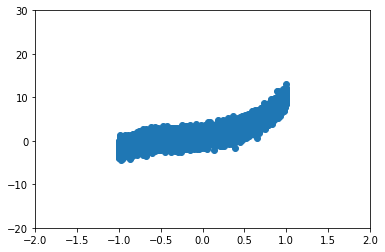

<Figure size 432x288 with 0 Axes>

In [5]:
printPolyBasis(4, 1, [1, 2, 3, 4])

In [6]:
# 2. Sequential Estimator


def WelfordEstimate(mean, var):  # Using online algorithm
    logStack = []
    print("Data point source function: N(%f, %f)\n" % (mean, var))
    Xbar = 0
    prev_Xbar = 1
    sigma = 0
    prev_Sigma = 1
    iters = 1
    while abs(Xbar - prev_Xbar) >= 10 ** -3 or abs(sigma - prev_Sigma) >= 10 ** -3:
        # set a maximum iteration
        if iters > 10000:
            break

        newData = BoxMuller(mean, var)
        # initial condition
        if iters == 1:
            Xbar = newData
            sigma = 0
        else:
            prev_Xbar = Xbar
            prev_Sigma = sigma
            Xbar = prev_Xbar + (newData - prev_Xbar) / iters
            sigma = (
                prev_Sigma
                + ((newData - prev_Xbar) * (newData - Xbar) - prev_Sigma) / iters
            )
        # Output log
        if iters % 200 == 0 or iters <= 3:
            logStack.append([iters, newData, Xbar, sigma])
        iters += 1
    logStack.append([iters, newData, Xbar, sigma])  # final result
    for i in range(len(logStack)):
        print("[%d] Add data point: %f" % (logStack[i][0], logStack[i][1]))
        print("Mean = %f, Variance = %f" % (logStack[i][2], logStack[i][3]))

$$\bar{x}_n = \bar{x}_{n-1} + \frac{x_n - \bar{x}_{n-1}}{n}$$
$$\sigma^2_n = \sigma^2_{n-1} + \frac{(x_n - \bar{x}_{n-1})(x_n - \bar{x}_n) - \sigma^2_{n-1}}{n}$$

In [7]:
WelfordEstimate(3, 5)

Data point source function: N(3.000000, 5.000000)

[1] Add data point: 6.685996
Mean = 6.685996, Variance = 0.000000
[2] Add data point: 4.345505
Mean = 5.515750, Variance = 1.369474
[3] Add data point: 4.605833
Mean = 5.212445, Variance = 1.096971
[200] Add data point: -0.443286
Mean = 3.015027, Variance = 5.265536
[400] Add data point: 0.261965
Mean = 2.993500, Variance = 5.253154
[600] Add data point: 6.004422
Mean = 3.047866, Variance = 5.118942
[800] Add data point: 5.733696
Mean = 3.063772, Variance = 5.088184
[1000] Add data point: 3.051948
Mean = 3.056624, Variance = 5.145944
[1200] Add data point: 3.572452
Mean = 3.037988, Variance = 5.013669
[1400] Add data point: 6.077754
Mean = 3.020350, Variance = 5.099900
[1600] Add data point: 2.817469
Mean = 3.014150, Variance = 5.211729
[1800] Add data point: 3.604939
Mean = 3.004370, Variance = 5.125723
[1921] Add data point: 1.117596
Mean = 3.005107, Variance = 5.066618


In [8]:
# 3. Baysian Linear regression


def drawPredDist(a, C, w):
    n = len(w)
    X = np.linspace(-2, 2)
    var_log = []
    for x in X:
        vecX = np.array([[x ** i for i in range(n)]])
        pred_var = 1 / a + np.dot(vecX.dot(np.linalg.inv(C)), vecX.T)
        var_log.append(pred_var[0][0])
    return np.array(var_log)


# pred_var = 1 / a + np.dot(vecX.dot(np.linalg.inv(C)), vecX.T)
def BLR(b, n, a, w, log=True):
    # init
    iters = 0
    incomeData = [[], []]
    prior_cov = b ** -1 * np.identity(n)  # arbitrary value
    prior_mean = np.zeros((n, 1))  # 0s
    posterior_cov = None
    posterior_mean = None
    X = y = None
    converge = False

    while True:
        # set maximum iters=10000
        if iters >= 10000:
            break
        iters += 1
        # New data incoming:
        incomeX, incomeY = polyBasis(n, a, w)  # new data comes from ground truth
        incomeData[0].append(incomeX)
        incomeData[1].append(incomeY)

        if iters == 1:
            X = np.array([[incomeX ** i for i in range(n)]])
            y = np.array([[incomeY]])
        else:
            X = np.concatenate((X, [[incomeX ** i for i in range(n)]]))
            y = np.concatenate((y, [[incomeY]]))

        prev_cov = posterior_cov
        vecX = np.array([[incomeX ** i for i in range(n)]])

        # COV(C) = (aX^TX + bI)^-1
        # mu = aC^-1X^Ty
        C = a * X.T.dot(X) + b * np.identity(n)
        posterior_cov = np.linalg.inv(C)
        posterior_mean = a * np.dot(np.linalg.inv(C), X.T).dot(y)

        # save mu for iter=10 and 50
        if iters == 10:
            mu_10 = posterior_mean
        if iters == 50:
            mu_50 = posterior_mean

        pred_mean = vecX.dot(posterior_mean)[0]
        pred_var = 1 / a + np.dot(vecX.dot(np.linalg.inv(C)), vecX.T)

        if iters == 10:
            var_10 = drawPredDist(a, C, posterior_mean)
        if iters == 50:
            var_50 = drawPredDist(a, C, posterior_mean)

        # check if converge
        converge = True
        if iters > 100:
            sub_cov = posterior_cov - prev_cov
            for rows in sub_cov:
                for item in rows:
                    if abs(item) > 10 ** -4:
                        converge = False
                        break
            if converge == True:
                break

        # Print log
        if iters % 50 == 0 and log == True:
            print("[%d] Add data point: (%f, %f) " % (iters, incomeX, incomeY))
            print("\nPosterior mean:")
            print(posterior_mean)
            print("\nPosterior variance:")
            print(posterior_cov)
            print("\nPredictive distribution ~ N(%f, %f)" % (pred_mean, pred_var))
            print("--------------------------------------------------")
        # update prior
        prior_cov = posterior_cov
        prior_mean = posterior_mean

    # Print predict result
    if log == True:
        print("[%d] Add data point: (%f, %f) " % (iters, incomeX, incomeY))
        print("\nPosterior mean:")
        print(posterior_mean)
        print("\nPosterior variance:")
        print(posterior_cov)
        print("\nPredictive distribution ~ N(%f, %f)" % (pred_mean, pred_var))
        print("--------------------------------------------------")

    # --- Print result: ---
    plt.figure(figsize=(15, 13))
    # Plot ground truth:
    plt.subplot(2, 2, 1)
    plt.title("Ground truth", fontsize=22)
    plt.xlim(-2, 2)
    plt.ylim(-20, 30)
    truthX = np.linspace(-2, 2)
    polyFunc_Truth = np.polynomial.polynomial.Polynomial(w)
    plt.plot(truthX, polyFunc_Truth(truthX), "k", linewidth=3)
    plt.plot(truthX, polyFunc_Truth(truthX) + a, "r", linewidth=3)
    plt.plot(truthX, polyFunc_Truth(truthX) - a, "r", linewidth=3)

    # Plot After 10 incomes
    plt.subplot(2, 2, 3)
    plt.title("After 10 incomes", fontsize=22)
    plt.xlim(-2, 2)
    plt.ylim(-20, 30)
    plt.scatter(incomeData[0][:10], incomeData[1][:10])
    polyFunc_10 = np.polynomial.polynomial.Polynomial(mu_10.flatten())
    plt.plot(np.linspace(-2, 2), polyFunc_10(np.linspace(-2, 2)), "k", linewidth=3)
    plt.plot(
        np.linspace(-2, 2), polyFunc_10(np.linspace(-2, 2)) + var_10, "r", linewidth=3
    )
    plt.plot(
        np.linspace(-2, 2), polyFunc_10(np.linspace(-2, 2)) - var_10, "r", linewidth=3
    )

    # Plot After 50 incomes
    plt.subplot(2, 2, 4)
    plt.title("After 50 incomes", fontsize=22)
    plt.xlim(-2, 2)
    plt.ylim(-20, 30)
    plt.scatter(incomeData[0][:50], incomeData[1][:50])
    polyFunc_50 = np.polynomial.polynomial.Polynomial(mu_50.flatten())
    plt.plot(np.linspace(-2, 2), polyFunc_50(np.linspace(-2, 2)), "k", linewidth=3)
    plt.plot(
        np.linspace(-2, 2), polyFunc_50(np.linspace(-2, 2)) + var_50, "r", linewidth=3
    )
    plt.plot(
        np.linspace(-2, 2), polyFunc_50(np.linspace(-2, 2)) - var_50, "r", linewidth=3
    )

    # Plot predict result
    plt.subplot(2, 2, 2)
    plt.title("Predict result", fontsize=22)
    plt.xlim(-2, 2)
    plt.ylim(-20, 30)
    plt.scatter(incomeData[0], incomeData[1])
    polyFunc_Final = np.polynomial.polynomial.Polynomial(posterior_mean.flatten())
    plt.plot(np.linspace(-2, 2), polyFunc_Final(np.linspace(-2, 2)), "k", linewidth=3)
    # calculate final pred result
    var_res = drawPredDist(a, C, posterior_mean)
    plt.plot(
        np.linspace(-2, 2),
        polyFunc_Final(np.linspace(-2, 2)) + var_res,
        "r",
        linewidth=3,
    )
    plt.plot(
        np.linspace(-2, 2),
        polyFunc_Final(np.linspace(-2, 2)) - var_res,
        "r",
        linewidth=3,
    )

[50] Add data point: (-0.541456, 0.267659) 

Posterior mean:
[[0.9290846 ]
 [2.11009965]
 [2.77730213]
 [2.64915709]]

Posterior variance:
[[ 0.0383747   0.0075147  -0.0577101  -0.00841789]
 [ 0.0075147   0.18143523  0.00272763 -0.21411482]
 [-0.0577101   0.00272763  0.18696919  0.02288583]
 [-0.00841789 -0.21411482  0.02288583  0.38405764]]

Predictive distribution ~ N(0.180263, 1.038208)
--------------------------------------------------
[100] Add data point: (0.080444, 1.879097) 

Posterior mean:
[[0.90013645]
 [2.21945301]
 [2.82491515]
 [2.87342759]]

Posterior variance:
[[ 0.02205086  0.00818134 -0.03629853 -0.01321091]
 [ 0.00818134  0.11780173 -0.01299358 -0.15501282]
 [-0.03629853 -0.01299358  0.11279454  0.03978737]
 [-0.01321091 -0.15501282  0.03978737  0.27723164]]

Predictive distribution ~ N(1.098456, 1.023624)
--------------------------------------------------
[150] Add data point: (-0.971675, -1.801254) 

Posterior mean:
[[0.99217882]
 [2.24425964]
 [2.73123308]
 [3.048

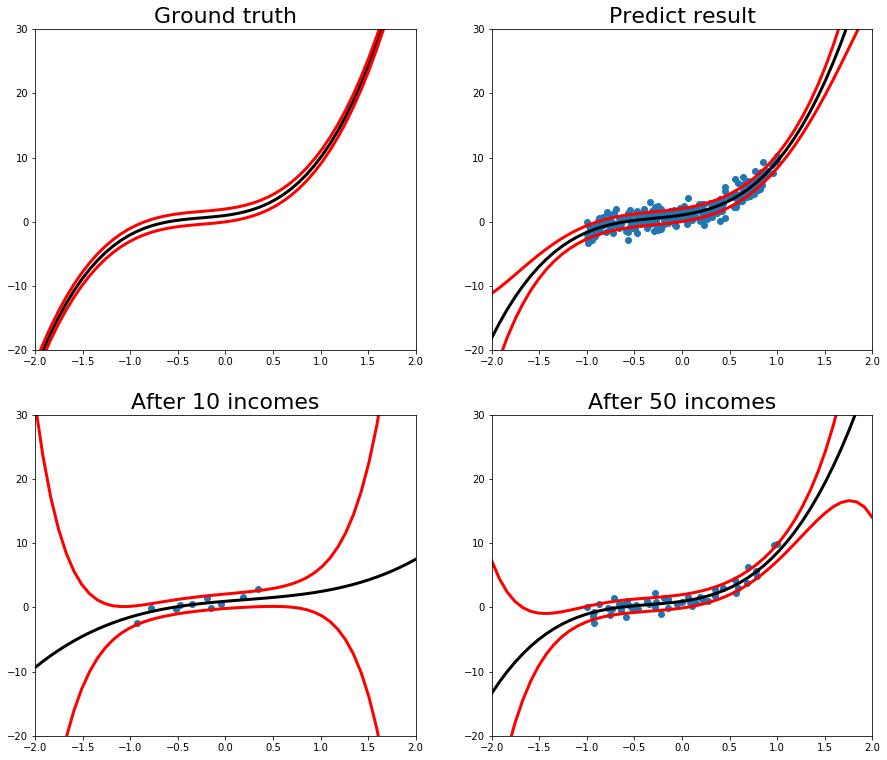

In [13]:
%%time
# case 1. b = 1, n = 4, a = 1, w = [1, 2, 3, 4]
BLR(1, 4, 1, [1, 2, 3, 4])

Wall time: 59.8 ms


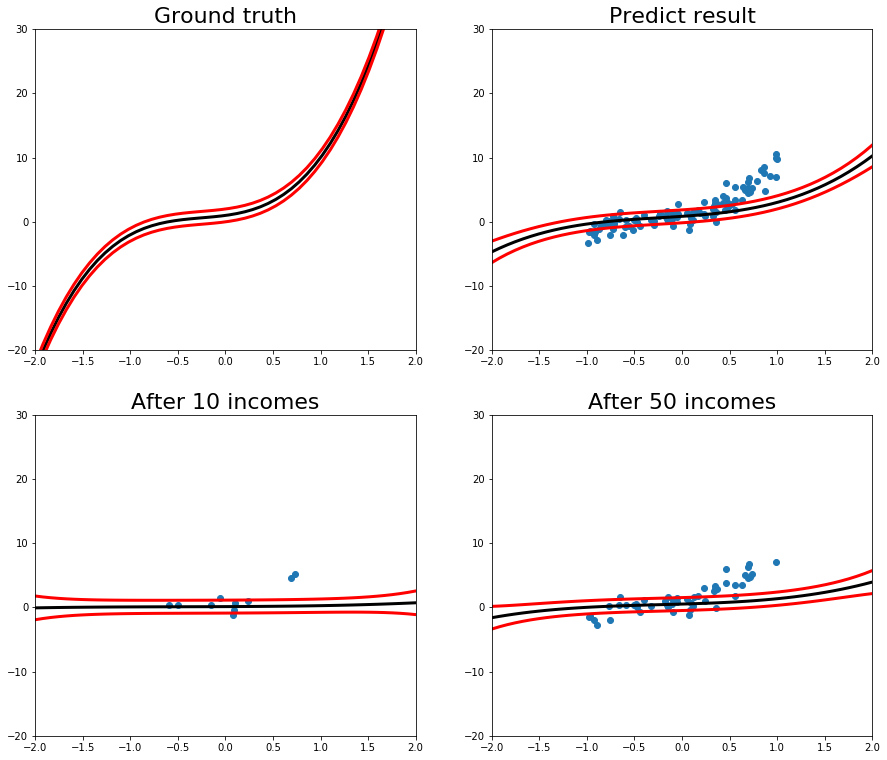

In [15]:
%%time
# case 2. b = 100, n = 4, a = 1, w = [1, 2, 3, 4]
BLR(100, 4, 1, [1, 2, 3, 4], log=False)

Wall time: 103 ms


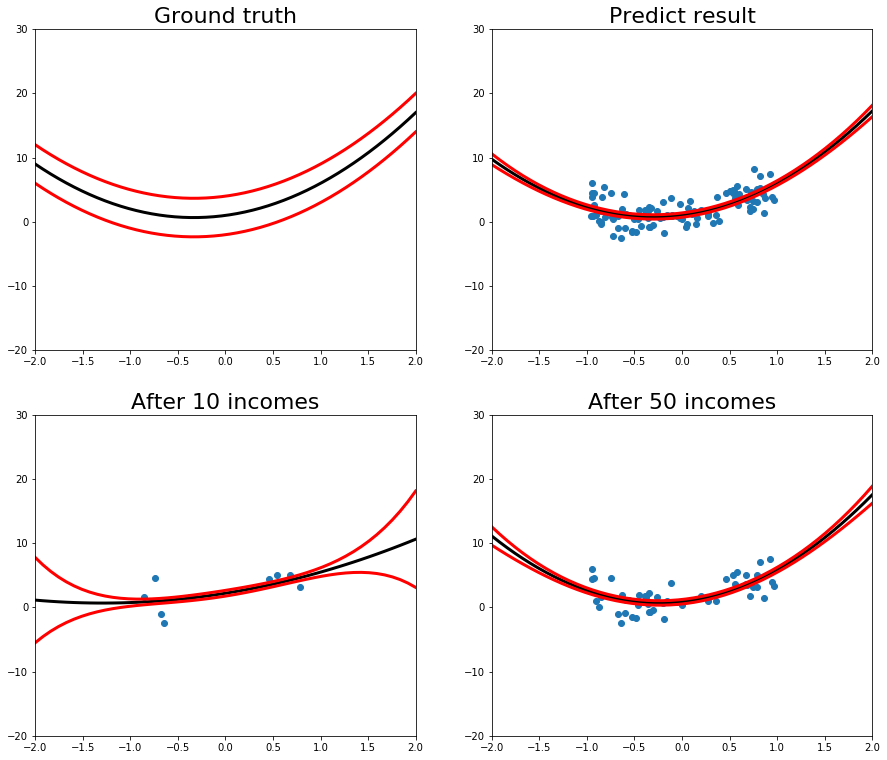

In [16]:
%%time
# case 3. b = 1, n = 3, a = 3, w = [1, 2, 3]
BLR(1, 3, 3, [1, 2, 3], log=False)